We start by fetching the shape of Brandenburg from OpenStreetMap:

In [1]:
! pip install -q geopandas requests

In [2]:
import geopandas as gp

In [3]:
search_url = 'https://nominatim.openstreetmap.org/search/?q=Brandenburg,%20Germany&format=geojson&polygon_geojson=1'
brandenburg = gp.read_file(search_url)[:1]
brandenburg

,place_id,osm_type,osm_id,display_name,place_rank,category,type,importance,icon,geometry
0,234763399,relation,62504,"Brandenburg, Deutschland",8,boundary,administrative,0.766083,https://nominatim.openstreetmap.org/images/map...,"MULTIPOLYGON (((11.26623 53.12205, 11.26780 53..."


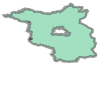

In [4]:
brandenburg.iloc[0]['geometry']

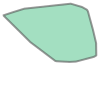

In [5]:
# let's remove the hole and simplify the shape
brandenburg_simple = brandenburg.convex_hull[0]
brandenburg_simple

Lets fetch products of interest from Scihub:

In [6]:
! pip install sentinelsat -q

In [7]:
from sentinelsat import SentinelAPI
from datetime import date
import datetime

In [8]:
# --------------------------------------------------------------------------#
# adjust these lines to search for pictures of the fire you want to look at #
# you should not need to changed anything below this cell                   #
# --------------------------------------------------------------------------#

start_date = date.today() - datetime.timedelta(weeks=4)
end_date = date.today()
footprint = brandenburg_simple.wkt

In [9]:
# you s
user = 'heyarne'
password='FhnNfPppxNbBm7wCoCGLnfly'
api = SentinelAPI(user, password)

# the "footprint" is what we can use to preselect a certain area;
# the lake is at (51.7874, 14.4226)
# footprint = 'POLYGON((14.359428613281251 51.806620319822734,14.466545312500001 51.806620319822734,14.466545312500001 51.757343872357566,14.359428613281251 51.757343872357566,14.359428613281251 51.806620319822734))'

In [10]:
products = api.query(footprint,
                     platformname='Sentinel-2',
                     processinglevel='Level-2A',
                     date=(start_date, end_date),
                     cloudcoverpercentage=(0,30))

In [11]:
print('Found ' + str(len(products)) + ' results')

Found 53 results


## Is our entire footprint covered by the search results?

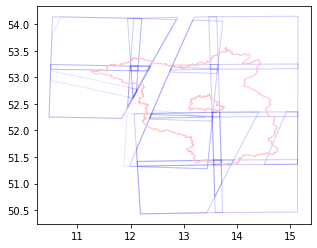

In [12]:
results = api.to_geodataframe(products)

ax = results.plot(color='', edgecolor='blue', alpha=0.1)
brandenburg.plot(ax=ax, color='', edgecolor='pink')

The previous approach was this:

> We're picking our product by the following criteria:
>
> - It should be taken on the same date
> - It should only use one projection
> - It should have only a low cloud covoer percentage

But now we need to screw the same projection part. The new approach looks like this:

- Group pictures by day
- Use the ones with the lowest cloud cover percentage

In [13]:
import pandas as pd
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)

In [14]:
results_per_day = results.groupby(results['ingestiondate'].dt.strftime('%Y-%m-%d')).count()['title']
most_results_per_day = results_per_day.sort_values(ascending=False).head(3)
most_results_per_day

ingestiondate
2020-06-27    11
2020-06-22    11
2020-07-18     6
Name: title, dtype: int64

Do those days cover our entire footprint?

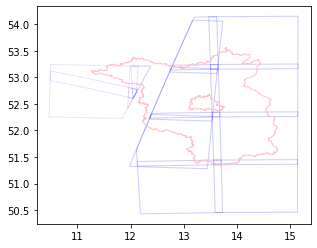

In [15]:
most_result_dates = set(most_results_per_day.index)

ax = results[results['ingestiondate'].dt.strftime('%Y-%m-%d').isin(most_result_dates)].plot(color='', edgecolor='blue', alpha=0.1)
brandenburg.plot(ax=ax, color='', edgecolor='pink')

Nicey. Does one day cover all?

/home/rus/.anaconda/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


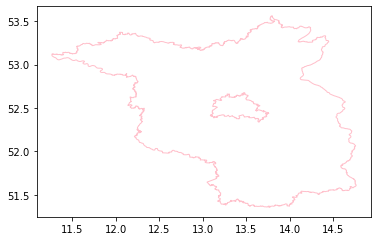

In [16]:
ax = results[results['ingestiondate'].dt.strftime('%Y-%m-%d') == '2020-06-16'].plot(color='', edgecolor='blue', alpha=0.1)
brandenburg.plot(ax=ax, color='', edgecolor='pink')

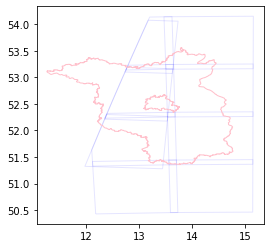

In [17]:
ax = results[results['ingestiondate'].dt.strftime('%Y-%m-%d') == '2020-06-22'].plot(color='', edgecolor='blue', alpha=0.1)
brandenburg.plot(ax=ax, color='', edgecolor='pink')

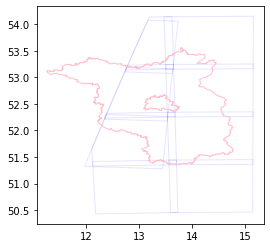

In [18]:
ax = results[results['ingestiondate'].dt.strftime('%Y-%m-%d') == '2020-06-27'].plot(color='', edgecolor='blue', alpha=0.1)
brandenburg.plot(ax=ax, color='', edgecolor='pink')

Hmmm… that's not really ideal, is it? Let's take another approach and see for each date, regardless of how many results we have.

On 2020-07-18


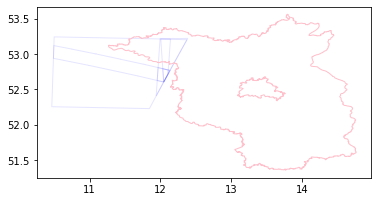

On 2020-07-15


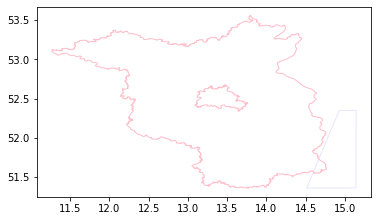

On 2020-07-13


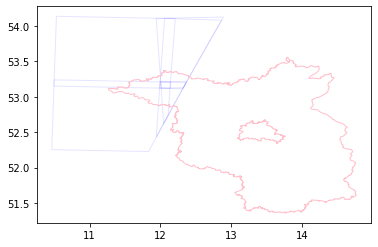

On 2020-07-12


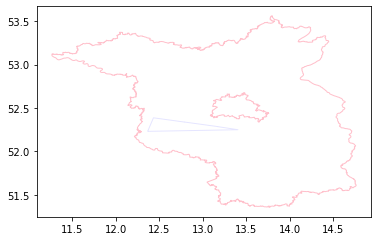

On 2020-07-04


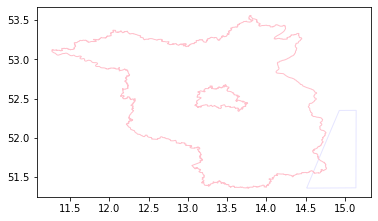

On 2020-06-30


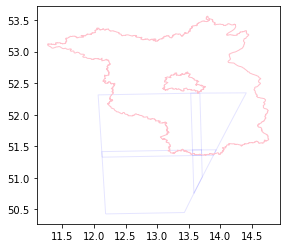

On 2020-06-27


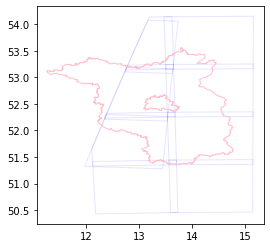

On 2020-06-25


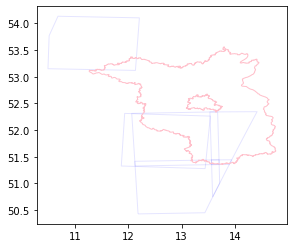

On 2020-06-23


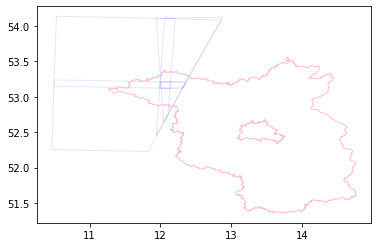

On 2020-06-22


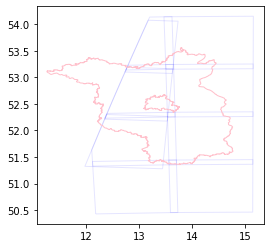

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

formatted = results['ingestiondate'].dt.strftime('%Y-%m-%d')
dates = formatted.unique()
for d in dates:
    on_this_date = results[formatted == d]
    print('On ' + d)
    ax = on_this_date.plot(color='', edgecolor='blue', alpha=0.1)
    brandenburg.plot(ax=ax, color='', edgecolor='pink')
    plt.show()

In [20]:
# let's just pick 16th and 22nd

In [21]:
# let's pick between 16th, 22nd and 27th

def calc_cloudcover(products):
    cloudcover = [v['cloudcoverpercentage'] for v in products if v['ingestiondate']]
    return sum(cloudcover) / len(products)

for d in [date(2020, 6, 16), date(2020, 6, 22), date(2020, 6, 27)]:
    subset = [v for v in products.values() if v['ingestiondate'].date() == d]
    cloudcover = calc_cloudcover(subset)
    print('cloud cover on {}: {}'.format(d.strftime('%d %B %Y'), cloudcover))

ZeroDivisionError: division by zero

In [ ]:
# Let's take the 27th!
to_download = {k: v for k, v in products.items() if v['ingestiondate'].date() in {date(2020, 6, 16), date(2020, 6, 22)}}

# they will not be in the same orbit of course
set(v['orbitnumber'] for v in to_download.values())

In [ ]:
# we create the directory structure we need for the following notebooks
! mkdir -p input/raster/brandenburg_mosaic

In [ ]:
print('Downloading {} files…'.format(len(to_download)))

In [ ]:
api.download_all(to_download, 'input/raster/brandenburg_mosaic')

## Previewing Downloaded Files

In [ ]:
from glob import glob
downloaded = glob('input/raster/brandenburg_mosaic/*.zip')

In [ ]:
downloaded

In [ ]:
from pathlib import Path

import rasterio as r
from rasterio import plot

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
Path(downloaded[1]).name

In [ ]:
import zipfile

def band_paths(p, bands, resolution=None):
    '''
    Given a zip file at `p`, returns the paths inside p to the raster files containing
    information for the given bands. Because some bands are available in more than one
    resolution, this can be filtered by prodiding a third parameter (e.g. resolution='10m').
    
    The returned paths are formatted in the zip scheme as per Apache Commons VFS and can
    thus be directly opened by rasterio.
    '''
    with zipfile.ZipFile(p) as f:
        files = f.namelist()
        rasters = [f for f in files if f.endswith('.jp2')]
        rasters = ['zip+file://' + p + '!/' + r for r in rasters for b in bands if b in r and (not resolution or resolution in r)]
        return rasters

In [ ]:
def rgb_paths(zip_file, resolution='10m'):
    return band_paths(zip_file, ['B02', 'B03', 'B04'], resolution)

In [ ]:
# preview the first downloaded image
with r.open(band_paths(downloaded[3], ['TCI'], '20m')[0]) as true_color:
    # we do not need
    fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
    plot.show((true_color, 1), ax=axr, cmap='Reds', title='red channel')
    plot.show((true_color, 2), ax=axg, cmap='Greens', title='green channel')
    plot.show((true_color, 3), ax=axb, cmap='Blues', title='blue channel')
    plt.show()

In [ ]:
# plotting the combined rgb image
true_color = r.open(band_paths(downloaded[3], ['TCI'], '20m')[0])

In [ ]:
# note that in order to get the real colors, we need to reverse the bands into "rasterio band order"
plt.figure(figsize=(20,20))
plot.show(true_color.read()[::-1], transform=true_color.transform)
plt.show()

## Creating a True-Color Mosaic

In [ ]:
from rasterio.merge import merge

In [ ]:
test = [r.open(band_paths(f, ['TCI'], '60m')[0]) for f in downloaded[:2]]
test

In [ ]:
test_mosaic, test_trans = merge(test)

In [ ]:
plt.figure(figsize=(8,16))
plot.show(test_mosaic)

In [ ]:
# coolcoolcool

In [ ]:
downloaded

In [ ]:
mosaic, mosaic_transform = merge([r.open(band_paths(f, ['TCI'], '20m')[0]) for f in downloaded if 'T33' in f])

In [ ]:
plt.figure(figsize=(8,16))
plot.show(mosaic, transform=mosaic_transform)

In [ ]:
# we need to make sure both have the same CRS if we want to plot them on top of each other
src_meta = r.open(band_paths(downloaded[0], ['TCI'], '60')[0]).meta
src_meta

In [ ]:
fig, (ax) = plt.subplots(1, 1, figsize=(8,16))
plot.show(mosaic, transform=mosaic_transform, ax=ax)
brandenburg.to_crs(src_meta['crs']).plot(ax=ax, color='', edgecolor='pink')
plt.show()